In [1]:
%load_ext autoreload
%autoreload 2
from cs285.envs.pendulum.pendulum_env import PendulumEnv
from cs285.envs.dt_sampler import ConstantSampler
from cs285.infrastructure.replay_buffer import ReplayBufferTrajectories
from cs285.infrastructure.utils import sample_n_trajectories, RandomPolicy
from cs285.agents.ode_agent import ODEAgent
from typing import Callable, Optional, Tuple, Sequence
import numpy as np
import gym
from cs285.infrastructure import pytorch_util as ptu
from tqdm import trange
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
from diffrax import diffeqsolve, Dopri5
import optax
import matplotlib.pyplot as plt
import wandb
import pprint
import pprint

In [2]:
key = jax.random.PRNGKey(0)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
def test_true_dynamics_agent(agent, ntraj, plot=False):
    trajs, _ = sample_n_trajectories(agent.env, agent, ntraj=ntraj, max_length=200, key=key)
    rewards = [t["episode_statistics"]["r"] for t in trajs]
    if plot:
        plt.hist(rewards, bins=20)
    mean, std, min, max = np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)
    print("mean", mean)
    print("std", std)
    print("min", min)
    print("max", max)
    stats = {
        "mean": mean,
        "std": std,
        "min": min,
        "max": max
    }
    return rewards, stats

In [4]:
dt_sampler = ConstantSampler(dt=0.05)
env = PendulumEnv(
    dt_sampler=dt_sampler
)
mpc_dt_sampler = ConstantSampler(dt=0.05)
agent_key, key = jax.random.split(key)
neural_ode_name = "pendulum_true_dynamics"
neural_ode_kwargs = {
    "ode_dt0": 0.005,
}
optimizer_name = "adamw"
optimizer_kwargs = {"learning_rate": 1e-3}
mb_agent = ODEAgent(
    env=env,
    key=agent_key,
    neural_ode_name=neural_ode_name,
    neural_ode_kwargs=neural_ode_kwargs,
    optimizer_name=optimizer_name,
    optimizer_kwargs=optimizer_kwargs,
    ensemble_size=1,
    train_discount=1,
    mpc_horizon_steps=20,
    mpc_dt_sampler=mpc_dt_sampler,
    mpc_strategy="random",
    mpc_discount=0.95,
    mpc_num_action_sequences=1000,
    cem_num_iters=4,
    cem_num_elites=5,
    cem_alpha=1,
)

100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

mean -1198.1469
std 276.66138
min -1839.6028
max -721.12476


([-1715.5911,
  -1075.523,
  -1256.1973,
  -1673.6987,
  -1793.1582,
  -1317.0759,
  -1070.4153,
  -1278.8779,
  -1353.1873,
  -992.12024,
  -1363.3391,
  -1072.8632,
  -1138.0256,
  -1346.6162,
  -1444.9705,
  -1159.9937,
  -1080.5519,
  -870.8106,
  -1080.271,
  -1740.8087,
  -1316.4354,
  -1297.7012,
  -1369.384,
  -1097.9888,
  -761.76904,
  -1785.231,
  -1638.9424,
  -1126.6602,
  -1072.7823,
  -1531.939,
  -1298.7985,
  -1072.0841,
  -1211.3765,
  -1099.9697,
  -876.459,
  -1183.5226,
  -901.4381,
  -873.0941,
  -1109.0576,
  -889.7103,
  -1073.5306,
  -1362.0928,
  -1596.7524,
  -765.11926,
  -1358.604,
  -1381.981,
  -1839.6028,
  -1140.6223,
  -970.66235,
  -866.9221,
  -1414.1278,
  -1369.7277,
  -1366.863,
  -869.23535,
  -777.3425,
  -1289.4082,
  -1167.5671,
  -1725.9231,
  -909.00366,
  -1067.5465,
  -1467.0972,
  -1289.7932,
  -1082.6465,
  -1170.4003,
  -1079.8466,
  -986.9471,
  -1100.6404,
  -1308.3818,
  -883.3982,
  -750.3158,
  -1169.0527,
  -1797.0911,
  -1419.682

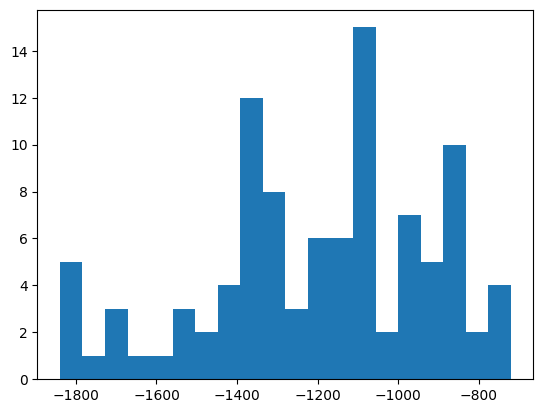

In [5]:
test_true_dynamics_agent(mb_agent, ntraj=100, plot=True)

In [9]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
wandb: Currently logged in as: zekai-wang. Use `wandb login --relogin` to force relogin
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [11]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'mean',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'mpc_horizon_steps': {
        'values': [1, 2, 5, 10, 20, 50, 100, 200]
        },
    'mpc_discount': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]
        },
    "mpc_num_action_sequences": {
        'values': [100, 200, 500, 1000, 2000, 5000]
        },
    'mpc_strategy': {
        'values': ["random", "cem"]
        },
    'cem_num_iters': {
        'values': [2, 4, 8, 16],
        },
    'cem_num_elites': {
        'values': [1, 2, 4, 8, 16, 32, 64],
        },
    'cem_alpha': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5],
        },
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)


{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'mean'},
 'parameters': {'cem_alpha': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'cem_num_elites': {'values': [1, 2, 4, 8, 16, 32, 64]},
                'cem_num_iters': {'values': [2, 4, 8, 16]},
                'mpc_discount': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'mpc_horizon_steps': {'values': [1,
                                                 2,
                                                 5,
                                                 10,
                                                 20,
                                                 50,
                                                 100,
                                                 200]},
                'mpc_num_action_sequences': {'values': [100,
                                                        200,
                                                        500,
                                     

In [12]:
sweep_id = wandb.sweep(sweep_config, project="cs285_proj_get_action_true_dynamics_updated")

Create sweep with ID: ok4muk7m
Sweep URL: https://wandb.ai/zekai-wang/cs285_proj_get_action_true_dynamics_updated/sweeps/ok4muk7m


In [13]:
key = jax.random.PRNGKey(0)

In [14]:
def evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config
        dt_sampler = ConstantSampler(dt=0.05)
        env = PendulumEnv(
            dt_sampler=dt_sampler
        )
        mpc_dt_sampler = ConstantSampler(dt=0.05)
        neural_ode_name = "pendulum_true_dynamics"
        neural_ode_kwargs = {
            "ode_dt0": 0.005,
        }
        optimizer_name = "adamw"
        optimizer_kwargs = {"learning_rate": 1e-3}
        agent = ODEAgent(
            env=env,
            key=key,
            neural_ode_name=neural_ode_name,
            neural_ode_kwargs=neural_ode_kwargs,
            optimizer_name=optimizer_name,
            optimizer_kwargs=optimizer_kwargs,
            ensemble_size=1,
            train_discount=1,
            mpc_horizon_steps=config.mpc_horizon_steps,
            mpc_dt_sampler=mpc_dt_sampler,
            mpc_strategy=config.mpc_strategy,
            mpc_discount=config.mpc_discount,
            mpc_num_action_sequences=config.mpc_num_action_sequences,
            cem_num_iters=config.cem_num_iters,
            cem_num_elites=config.cem_num_elites,
            cem_alpha=config.cem_alpha,
        )
        rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
        wandb.log({"rewards": rewards,
                   "min": stats["min"],
                   "max": stats["max"],
                   "mean": stats["mean"],
                   "std": stats["std"],})


In [15]:
wandb.agent(sweep_id, evaluate, count=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: 48p88t7v with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


 20%|██        | 2/10 [00:03<00:14,  1.82s/it]Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    Exception in thread self.run()Exception in thread NetStatThr
IntMsgThr:
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 917, in run
:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 980, in _bootstrap_inner
        self._target(*self._args, **self._kwargs)    self.run()
self.run()
  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 286, in check_stop_status

  File "/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/threading.py", line 917, in run
  File "/home/zekai/minicond

mean -1368.8225
std 272.99777
min -1751.8207
max -885.83936


/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


max,▁
mean,▁
min,▁
std,▁
max,-885.83936
mean,-1368.82251
min,-1751.82068
std,272.99777


wandb: Agent Starting Run: cm3jkz4i with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


mean -1160.4425
std 335.43506
min -1671.1611
max -632.54517


max,▁
mean,▁
min,▁
std,▁
max,-632.54517
mean,-1160.4425
min,-1671.16113
std,335.43506


wandb: Agent Starting Run: x2x2t88s with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1172.1118
std 236.20064
min -1626.6975
max -894.81177


max,▁
mean,▁
min,▁
std,▁
max,-894.81177
mean,-1172.11182
min,-1626.69751
std,236.20064


wandb: Agent Starting Run: 246837bm with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1319.9316
std 278.18747
min -1789.3433
max -864.2131


max,▁
mean,▁
min,▁
std,▁
max,-864.21307
mean,-1319.93164
min,-1789.34326
std,278.18747


wandb: Agent Starting Run: jjlmrv48 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


mean -1253.3903
std 305.25302
min -1809.4779
max -748.06274


max,▁
mean,▁
min,▁
std,▁
max,-748.06274
mean,-1253.39026
min,-1809.47791
std,305.25302


wandb: Agent Starting Run: l6j104ki with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1380.198
std 247.03847
min -1728.9589
max -1070.552


max,▁
mean,▁
min,▁
std,▁
max,-1070.552
mean,-1380.198
min,-1728.95886
std,247.03847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dja2czbh with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


mean -1291.184
std 349.06216
min -1796.3738
max -760.8245


max,▁
mean,▁
min,▁
std,▁
max,-760.82452
mean,-1291.18396
min,-1796.37378
std,349.06216


wandb: Agent Starting Run: lk292qt6 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


mean -1164.2888
std 274.22797
min -1634.7144
max -770.15784


max,▁
mean,▁
min,▁
std,▁
max,-770.15784
mean,-1164.28882
min,-1634.71436
std,274.22797


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7vpjn5wt with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


mean -1214.9603
std 262.16977
min -1682.6533
max -875.84155


max,▁
mean,▁
min,▁
std,▁
max,-875.84155
mean,-1214.96033
min,-1682.65332
std,262.16977


wandb: Agent Starting Run: x6vrf7er with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1289.3376
std 307.50577
min -1872.4172
max -859.4885


max,▁
mean,▁
min,▁
std,▁
max,-859.48853
mean,-1289.33765
min,-1872.41724
std,307.50577


wandb: Agent Starting Run: nuamm126 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1233.3231
std 261.58942
min -1662.9427
max -865.40137


max,▁
mean,▁
min,▁
std,▁
max,-865.40137
mean,-1233.32312
min,-1662.94275
std,261.58942


wandb: Agent Starting Run: ka6ftbon with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1259.0624
std 250.91978
min -1861.1592
max -960.386


max,▁
mean,▁
min,▁
std,▁
max,-960.38599
mean,-1259.06238
min,-1861.15918
std,250.91978


wandb: Agent Starting Run: nqvau353 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


mean -1308.6792
std 315.9739
min -1731.908
max -791.1249


max,▁
mean,▁
min,▁
std,▁
max,-791.12488
mean,-1308.6792
min,-1731.90796
std,315.97391


wandb: Agent Starting Run: gvuh1ikc with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


mean -1324.8943
std 244.92871
min -1704.855
max -830.54346


max,▁
mean,▁
min,▁
std,▁
max,-830.54346
mean,-1324.89429
min,-1704.85498
std,244.92871


wandb: Agent Starting Run: fyqjx7ce with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


mean -1339.5402
std 331.1469
min -1834.5083
max -860.12463


max,▁
mean,▁
min,▁
std,▁
max,-860.12463
mean,-1339.54016
min,-1834.5083
std,331.14691


wandb: Agent Starting Run: wme64bf6 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


mean -1325.9243
std 353.90198
min -1812.6294
max -761.00323


max,▁
mean,▁
min,▁
std,▁
max,-761.00323
mean,-1325.92432
min,-1812.62939
std,353.90198


wandb: Agent Starting Run: j1mnclrd with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


mean -1145.6116
std 216.28084
min -1661.4275
max -939.4071


max,▁
mean,▁
min,▁
std,▁
max,-939.4071
mean,-1145.61157
min,-1661.42749
std,216.28084


wandb: Agent Starting Run: 6qmu3mrh with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1366.0017
std 328.05676
min -1756.1707
max -887.9665


max,▁
mean,▁
min,▁
std,▁
max,-887.96649
mean,-1366.00171
min,-1756.17065
std,328.05676


wandb: Agent Starting Run: bg5ssmsg with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


mean -1331.2542
std 317.20187
min -1822.742
max -837.68176


max,▁
mean,▁
min,▁
std,▁
max,-837.68176
mean,-1331.25415
min,-1822.74194
std,317.20187


wandb: Agent Starting Run: fqo2cpc5 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1418.8916
std 254.7926
min -1794.4857
max -964.2369


max,▁
mean,▁
min,▁
std,▁
max,-964.23688
mean,-1418.8916
min,-1794.48572
std,254.7926


wandb: Agent Starting Run: db0ciymn with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1060.4124
std 198.80756
min -1379.7148
max -797.72095


max,▁
mean,▁
min,▁
std,▁
max,-797.72095
mean,-1060.41235
min,-1379.71484
std,198.80756


wandb: Agent Starting Run: dfi74s0h with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1328.5276
std 262.85782
min -1832.2727
max -963.12866


max,▁
mean,▁
min,▁
std,▁
max,-963.12866
mean,-1328.52759
min,-1832.27271
std,262.85782


wandb: Agent Starting Run: vwq7l446 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1281.0676
std 342.12115
min -1807.0696
max -747.62463


max,▁
mean,▁
min,▁
std,▁
max,-747.62463
mean,-1281.06763
min,-1807.06958
std,342.12115


wandb: Agent Starting Run: ddleltrx with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1179.5667
std 261.11707
min -1697.8394
max -868.2554


max,▁
mean,▁
min,▁
std,▁
max,-868.25537
mean,-1179.56665
min,-1697.83936
std,261.11707


wandb: Agent Starting Run: dljh5tvu with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1145.6185
std 322.6526
min -1807.2755
max -851.90283


max,▁
mean,▁
min,▁
std,▁
max,-851.90283
mean,-1145.61853
min,-1807.27551
std,322.65259


wandb: Agent Starting Run: e016x52r with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


mean -1175.4014
std 348.4563
min -1811.4885
max -766.0309


max,▁
mean,▁
min,▁
std,▁
max,-766.03088
mean,-1175.40137
min,-1811.48853
std,348.4563


wandb: Agent Starting Run: h69lufo6 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1308.2615
std 189.66675
min -1650.4998
max -959.57983


max,▁
mean,▁
min,▁
std,▁
max,-959.57983
mean,-1308.26147
min,-1650.49976
std,189.66675


wandb: Agent Starting Run: iidmjhqa with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1305.7693
std 337.53864
min -1704.9857
max -751.0709


max,▁
mean,▁
min,▁
std,▁
max,-751.07092
mean,-1305.76929
min,-1704.98572
std,337.53864


wandb: Agent Starting Run: toq8trxp with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


mean -1235.4666
std 304.0858
min -1708.2769
max -777.0954


max,▁
mean,▁
min,▁
std,▁
max,-777.0954
mean,-1235.46655
min,-1708.27686
std,304.08578


wandb: Agent Starting Run: mmwl13f2 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


mean -1379.9244
std 337.4129
min -1786.8221
max -876.0994


max,▁
mean,▁
min,▁
std,▁
max,-876.09943
mean,-1379.92444
min,-1786.82214
std,337.4129


wandb: Agent Starting Run: wsr7z9yv with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


mean -1162.076
std 139.51476
min -1432.876
max -912.2076


max,▁
mean,▁
min,▁
std,▁
max,-912.20758
mean,-1162.07605
min,-1432.87598
std,139.51476


wandb: Agent Starting Run: p0lsffpb with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


mean -1277.2253
std 257.84543
min -1694.237
max -785.4103


max,▁
mean,▁
min,▁
std,▁
max,-785.41028
mean,-1277.22534
min,-1694.23706
std,257.84543


wandb: Agent Starting Run: ehjgxgri with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


mean -1260.0793
std 321.4868
min -1766.2046
max -898.9603


max,▁
mean,▁
min,▁
std,▁
max,-898.96033
mean,-1260.07935
min,-1766.20459
std,321.48679


wandb: Agent Starting Run: 2xbki2uh with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


mean -1212.0873
std 235.46313
min -1540.3375
max -864.8971


max,▁
mean,▁
min,▁
std,▁
max,-864.89709
mean,-1212.08728
min,-1540.33752
std,235.46313


wandb: Agent Starting Run: 15xs20cr with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


mean -1315.4016
std 342.5913
min -1806.6589
max -889.40027


max,▁
mean,▁
min,▁
std,▁
max,-889.40027
mean,-1315.40161
min,-1806.65894
std,342.59131


wandb: Agent Starting Run: ybijrqyd with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


mean -1169.7751
std 277.41992
min -1676.272
max -765.4935


max,▁
mean,▁
min,▁
std,▁
max,-765.49353
mean,-1169.77515
min,-1676.27197
std,277.41992


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sudgn791 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


mean -1255.9666
std 275.9796
min -1658.7927
max -871.4061


max,▁
mean,▁
min,▁
std,▁
max,-871.40613
mean,-1255.96655
min,-1658.79272
std,275.97961


wandb: Agent Starting Run: nfugcyl0 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


mean -1131.0264
std 256.90244
min -1747.8458
max -915.6435


max,▁
mean,▁
min,▁
std,▁
max,-915.64349
mean,-1131.02637
min,-1747.84583
std,256.90244


wandb: Agent Starting Run: hdoz29zf with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


mean -1109.11
std 277.16943
min -1739.5078
max -742.2825


max,▁
mean,▁
min,▁
std,▁
max,-742.28247
mean,-1109.10999
min,-1739.50781
std,277.16943


wandb: Agent Starting Run: wnl742o0 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1281.9583
std 303.2645
min -1644.6613
max -865.74335


max,▁
mean,▁
min,▁
std,▁
max,-865.74335
mean,-1281.95825
min,-1644.66125
std,303.2645


wandb: Agent Starting Run: dlvml0rj with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


mean -1156.5125
std 347.0768
min -1851.3135
max -748.53064


max,▁
mean,▁
min,▁
std,▁
max,-748.53064
mean,-1156.51245
min,-1851.31348
std,347.07681


wandb: Agent Starting Run: ugo6jkfv with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


mean -1301.6637
std 360.948
min -1860.9885
max -866.9353


max,▁
mean,▁
min,▁
std,▁
max,-866.9353
mean,-1301.6637
min,-1860.98853
std,360.948


wandb: Agent Starting Run: t5xffnkl with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1236.5881
std 280.08017
min -1796.8994
max -871.4387


max,▁
mean,▁
min,▁
std,▁
max,-871.43872
mean,-1236.58813
min,-1796.89941
std,280.08017


wandb: Agent Starting Run: ecokqy5i with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


mean -1324.4727
std 329.90866
min -1779.7454
max -853.55566


max,▁
mean,▁
min,▁
std,▁
max,-853.55566
mean,-1324.47266
min,-1779.74536
std,329.90866


wandb: Agent Starting Run: bs36odzw with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


mean -1311.3317
std 290.68488
min -1861.5535
max -880.4885


max,▁
mean,▁
min,▁
std,▁
max,-880.48853
mean,-1311.33167
min,-1861.55347
std,290.68488


wandb: Agent Starting Run: d9kv1d7u with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


mean -1155.2046
std 380.90805
min -1849.4736
max -751.0587


max,▁
mean,▁
min,▁
std,▁
max,-751.05872
mean,-1155.20459
min,-1849.47363
std,380.90805


wandb: Agent Starting Run: bfq2j98n with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1090.6594
std 348.196
min -1708.6108
max -627.8274


max,▁
mean,▁
min,▁
std,▁
max,-627.82739
mean,-1090.65942
min,-1708.61084
std,348.19601


wandb: Agent Starting Run: 3i3gab48 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


mean -1187.574
std 339.697
min -1809.2703
max -752.6034


max,▁
mean,▁
min,▁
std,▁
max,-752.60339
mean,-1187.57397
min,-1809.27026
std,339.69699


wandb: Agent Starting Run: xlbp9oll with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


mean -1183.105
std 297.1539
min -1656.151
max -732.812


max,▁
mean,▁
min,▁
std,▁
max,-732.81201
mean,-1183.10498
min,-1656.151
std,297.1539


wandb: Agent Starting Run: y1qi1jfv with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


mean -1289.9298
std 361.4654
min -1843.5892
max -717.72595


max,▁
mean,▁
min,▁
std,▁
max,-717.72595
mean,-1289.92981
min,-1843.58923
std,361.46539


wandb: Agent Starting Run: ke3kpmy5 with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


mean -1134.9773
std 287.70038
min -1575.0593
max -764.75714


max,▁
mean,▁
min,▁
std,▁
max,-764.75714
mean,-1134.97729
min,-1575.05933
std,287.70038


wandb: Agent Starting Run: mfl9ni9b with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


mean -1286.9467
std 344.98163
min -1815.3748
max -790.56726


max,▁
mean,▁
min,▁
std,▁
max,-790.56726
mean,-1286.94666
min,-1815.37476
std,344.98163


wandb: Agent Starting Run: pbkp79fh with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


mean -1206.8158
std 313.94543
min -1782.554
max -859.0941


max,▁
mean,▁
min,▁
std,▁
max,-859.09412
mean,-1206.8158
min,-1782.55396
std,313.94543


wandb: Agent Starting Run: 73ietlk7 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


mean -1145.2073
std 153.64545
min -1342.6375
max -869.70667


max,▁
mean,▁
min,▁
std,▁
max,-869.70667
mean,-1145.20728
min,-1342.63745
std,153.64545


wandb: Agent Starting Run: br7fow7t with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1380.2034
std 247.88675
min -1711.669
max -970.1911


max,▁
mean,▁
min,▁
std,▁
max,-970.1911
mean,-1380.20337
min,-1711.66895
std,247.88675


wandb: Agent Starting Run: 7ihz9e2c with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1212.8126
std 275.92957
min -1625.1586
max -891.19586


max,▁
mean,▁
min,▁
std,▁
max,-891.19586
mean,-1212.81262
min,-1625.15857
std,275.92957


wandb: Agent Starting Run: qn4who61 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


mean -1085.1796
std 259.10425
min -1604.2644
max -736.98816


max,▁
mean,▁
min,▁
std,▁
max,-736.98816
mean,-1085.17957
min,-1604.2644
std,259.10425


wandb: Agent Starting Run: 2kykarou with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


mean -1185.4568
std 267.01956
min -1497.8552
max -749.23846


max,▁
mean,▁
min,▁
std,▁
max,-749.23846
mean,-1185.45679
min,-1497.85522
std,267.01956


wandb: Agent Starting Run: x165jpb8 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


mean -1195.5797
std 305.48813
min -1754.2183
max -845.0111


max,▁
mean,▁
min,▁
std,▁
max,-845.01111
mean,-1195.57971
min,-1754.21826
std,305.48813


wandb: Agent Starting Run: 87okyxs9 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


mean -1190.904
std 290.26846
min -1811.5952
max -873.4375


max,▁
mean,▁
min,▁
std,▁
max,-873.4375
mean,-1190.90405
min,-1811.59521
std,290.26846


wandb: Agent Starting Run: tl1exfyb with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


mean -1171.1364
std 381.14987
min -1938.2712
max -738.5451


max,▁
mean,▁
min,▁
std,▁
max,-738.5451
mean,-1171.13635
min,-1938.27124
std,381.14987


wandb: Agent Starting Run: fl4pbuut with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


mean -1225.7504
std 253.46216
min -1601.5271
max -870.3392


max,▁
mean,▁
min,▁
std,▁
max,-870.33917
mean,-1225.75037
min,-1601.5271
std,253.46216


wandb: Agent Starting Run: v5gdr8c1 with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


mean -1325.9407
std 286.0732
min -1727.9459
max -748.0342


max,▁
mean,▁
min,▁
std,▁
max,-748.03418
mean,-1325.94067
min,-1727.94592
std,286.07321


wandb: Agent Starting Run: e0lfxwvp with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1248.0541
std 308.80817
min -1757.4994
max -749.6032


max,▁
mean,▁
min,▁
std,▁
max,-749.60321
mean,-1248.05408
min,-1757.49939
std,308.80817


wandb: Agent Starting Run: z3ealyfh with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


mean -1333.3987
std 323.98734
min -1802.2666
max -782.5547


max,▁
mean,▁
min,▁
std,▁
max,-782.55469
mean,-1333.39868
min,-1802.2666
std,323.98734


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 06x26vpq with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1376.031
std 274.0681
min -1746.9506
max -811.7743


max,▁
mean,▁
min,▁
std,▁
max,-811.77429
mean,-1376.03101
min,-1746.95056
std,274.06812


wandb: Agent Starting Run: 8d45pwtb with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


mean -1210.4695
std 234.09045
min -1570.788
max -883.8288


max,▁
mean,▁
min,▁
std,▁
max,-883.8288
mean,-1210.46948
min,-1570.78796
std,234.09045


wandb: Agent Starting Run: vwmx67ir with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


mean -1319.1261
std 218.3975
min -1621.8206
max -863.39124


max,▁
mean,▁
min,▁
std,▁
max,-863.39124
mean,-1319.1261
min,-1621.82056
std,218.39751


wandb: Agent Starting Run: r9wxcbcr with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


mean -1438.0288
std 308.49335
min -1826.0308
max -978.27844


max,▁
mean,▁
min,▁
std,▁
max,-978.27844
mean,-1438.02881
min,-1826.03076
std,308.49335


wandb: Agent Starting Run: xvn1w6pk with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


mean -1299.076
std 323.31464
min -1750.2788
max -784.4679


max,▁
mean,▁
min,▁
std,▁
max,-784.4679
mean,-1299.07605
min,-1750.27881
std,323.31464


wandb: Agent Starting Run: o2wl18nh with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


mean -1280.3842
std 235.06746
min -1788.3253
max -862.2379


max,▁
mean,▁
min,▁
std,▁
max,-862.23792
mean,-1280.38416
min,-1788.32532
std,235.06746


wandb: Agent Starting Run: p2x41sg4 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


mean -1342.5403
std 299.6917
min -1870.6536
max -862.86694


max,▁
mean,▁
min,▁
std,▁
max,-862.86694
mean,-1342.54028
min,-1870.65356
std,299.69171


wandb: Agent Starting Run: gf2yl508 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


mean -1159.5209
std 328.25
min -1755.5392
max -866.83124


max,▁
mean,▁
min,▁
std,▁
max,-866.83124
mean,-1159.52087
min,-1755.53918
std,328.25


wandb: Agent Starting Run: kborgb9x with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


mean -1247.6193
std 315.98
min -1719.2054
max -753.2404


max,▁
mean,▁
min,▁
std,▁
max,-753.24042
mean,-1247.61926
min,-1719.20544
std,315.98001


wandb: Agent Starting Run: sp70fw61 with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


mean -1191.506
std 249.8792
min -1810.8491
max -894.81085


max,▁
mean,▁
min,▁
std,▁
max,-894.81085
mean,-1191.50598
min,-1810.84912
std,249.8792


wandb: Agent Starting Run: ffrnz4qb with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


mean -1108.5139
std 283.40802
min -1659.2349
max -679.5001


max,▁
mean,▁
min,▁
std,▁
max,-679.50012
mean,-1108.51392
min,-1659.23486
std,283.40802


wandb: Agent Starting Run: vm1vdyom with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


mean -1146.1224
std 160.46446
min -1372.4745
max -879.66626


max,▁
mean,▁
min,▁
std,▁
max,-879.66626
mean,-1146.12244
min,-1372.47449
std,160.46446


wandb: Agent Starting Run: qh16ab5t with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


mean -1345.1628
std 317.59686
min -1758.4111
max -871.7427


max,▁
mean,▁
min,▁
std,▁
max,-871.74268
mean,-1345.16284
min,-1758.41113
std,317.59686


wandb: Agent Starting Run: zqajrrdj with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 2
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


mean -1238.6855
std 315.182
min -1668.4321
max -710.6528


max,▁
mean,▁
min,▁
std,▁
max,-710.65277
mean,-1238.68555
min,-1668.43213
std,315.18201


wandb: Agent Starting Run: uukna4sh with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


mean -1431.9863
std 276.7351
min -1811.5049
max -968.8311


max,▁
mean,▁
min,▁
std,▁
max,-968.83112
mean,-1431.98633
min,-1811.50488
std,276.73511


wandb: Agent Starting Run: msq06duh with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


mean -1381.2649
std 296.45508
min -1782.6815
max -972.78516


max,▁
mean,▁
min,▁
std,▁
max,-972.78516
mean,-1381.26489
min,-1782.68152
std,296.45508


wandb: Agent Starting Run: 1ptrjx8o with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1315.2356
std 356.55197
min -1808.1365
max -853.6538


max,▁
mean,▁
min,▁
std,▁
max,-853.65381
mean,-1315.2356
min,-1808.13647
std,356.55197


wandb: Agent Starting Run: c4lgtf2a with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


mean -1268.819
std 307.31158
min -1685.9613
max -866.5443


max,▁
mean,▁
min,▁
std,▁
max,-866.54431
mean,-1268.81897
min,-1685.9613
std,307.31158


wandb: Agent Starting Run: 1s3i7ft3 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1152.2273
std 295.01566
min -1671.2285
max -749.2793


max,▁
mean,▁
min,▁
std,▁
max,-749.2793
mean,-1152.22729
min,-1671.22852
std,295.01566


wandb: Agent Starting Run: rxlkesqy with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


mean -1297.3783
std 301.0483
min -1804.1279
max -822.7306


max,▁
mean,▁
min,▁
std,▁
max,-822.73059
mean,-1297.3783
min,-1804.12793
std,301.04831


wandb: Agent Starting Run: ykqxh95w with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 32
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 1
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 100
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


mean -1150.5627
std 228.27188
min -1631.2346
max -754.4673


max,▁
mean,▁
min,▁
std,▁
max,-754.46729
mean,-1150.56274
min,-1631.23462
std,228.27188


wandb: Agent Starting Run: mcqigp1j with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1261.957
std 262.12308
min -1840.0826
max -884.3689


max,▁
mean,▁
min,▁
std,▁
max,-884.3689
mean,-1261.95703
min,-1840.08264
std,262.12308


wandb: Agent Starting Run: ca4yaxiw with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 1
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.99
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


mean -1291.2878
std 234.02458
min -1693.5803
max -999.2748


max,▁
mean,▁
min,▁
std,▁
max,-999.27478
mean,-1291.28784
min,-1693.58032
std,234.02458


wandb: Agent Starting Run: ct6vg7dg with config:
wandb: 	cem_alpha: 0.8
wandb: 	cem_num_elites: 8
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


mean -1344.8064
std 297.38773
min -1816.894
max -784.28516


max,▁
mean,▁
min,▁
std,▁
max,-784.28516
mean,-1344.8064
min,-1816.89404
std,297.38773


wandb: Agent Starting Run: glopahfk with config:
wandb: 	cem_alpha: 0.95
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 200
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1386.3263
std 294.62094
min -1840.6211
max -864.7551


max,▁
mean,▁
min,▁
std,▁
max,-864.75513
mean,-1386.32629
min,-1840.62109
std,294.62094


wandb: Agent Starting Run: qtw1kaza with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 20
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


mean -1110.739
std 261.12662
min -1620.3611
max -852.84033


max,▁
mean,▁
min,▁
std,▁
max,-852.84033
mean,-1110.73901
min,-1620.36108
std,261.12662


wandb: Agent Starting Run: 1sh96t71 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 5
wandb: 	mpc_num_action_sequences: 200
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1178.3754
std 304.72522
min -1572.3945
max -746.48975


max,▁
mean,▁
min,▁
std,▁
max,-746.48975
mean,-1178.37537
min,-1572.39453
std,304.72522


wandb: Agent Starting Run: k40wvovq with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.95
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


mean -1143.2009
std 237.42201
min -1684.926
max -867.2285


max,▁
mean,▁
min,▁
std,▁
max,-867.22852
mean,-1143.20093
min,-1684.92603
std,237.42201


wandb: Agent Starting Run: mbunf8q9 with config:
wandb: 	cem_alpha: 0.9
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 2
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1383.9897
std 196.7398
min -1845.3081
max -1148.7828


max,▁
mean,▁
min,▁
std,▁
max,-1148.78284
mean,-1383.98975
min,-1845.30811
std,196.73981


wandb: Agent Starting Run: r7dh7x7x with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 8
wandb: 	mpc_discount: 0.9
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: random
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


mean -1236.3474
std 280.258
min -1711.8993
max -862.9424


max,▁
mean,▁
min,▁
std,▁
max,-862.94238
mean,-1236.34741
min,-1711.89929
std,280.258


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1j19mbb1 with config:
wandb: 	cem_alpha: 0.5
wandb: 	cem_num_elites: 2
wandb: 	cem_num_iters: 16
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 50
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


mean -1090.6086
std 241.47893
min -1733.9749
max -776.3515


max,▁
mean,▁
min,▁
std,▁
max,-776.3515
mean,-1090.60864
min,-1733.97485
std,241.47893


wandb: Agent Starting Run: lmc0rvnw with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 4
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 10
wandb: 	mpc_num_action_sequences: 500
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


mean -1387.9436
std 301.7238
min -1734.9336
max -875.39154


max,▁
mean,▁
min,▁
std,▁
max,-875.39154
mean,-1387.9436
min,-1734.93359
std,301.72379


wandb: Agent Starting Run: pe9ok9tj with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 64
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 5000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


mean -1287.4578
std 298.9417
min -1718.0896
max -758.911


max,▁
mean,▁
min,▁
std,▁
max,-758.91101
mean,-1287.45776
min,-1718.0896
std,298.94171


wandb: Agent Starting Run: 8rhj4fnw with config:
wandb: 	cem_alpha: 0.99
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.8
wandb: 	mpc_horizon_steps: 100
wandb: 	mpc_num_action_sequences: 1000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


mean -1189.502
std 357.77454
min -1913.8984
max -725.9192


max,▁
mean,▁
min,▁
std,▁
max,-725.91919
mean,-1189.50195
min,-1913.89844
std,357.77454


wandb: Agent Starting Run: hufe77y8 with config:
wandb: 	cem_alpha: 1
wandb: 	cem_num_elites: 16
wandb: 	cem_num_iters: 4
wandb: 	mpc_discount: 0.5
wandb: 	mpc_horizon_steps: 1
wandb: 	mpc_num_action_sequences: 2000
wandb: 	mpc_strategy: cem
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


mean -1353.9994
std 255.70158
min -1853.8348
max -1073.6519


max,▁
mean,▁
min,▁
std,▁
max,-1073.65186
mean,-1353.99939
min,-1853.83484
std,255.70158


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f82cc060f10>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe